In [7]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "testing-framework"))

In [9]:
def compute_cdf_vals(r, beta, xs, use_matlab = True, debug = False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs))):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gauss_density(z, x):
            return np.exp(-0.5 * (x/z)**2) / (np.sqrt(2*np.pi) * z)

        def gen_gamma_cdf(x):
            return prior_cdf.gammainc(beta, x**r)

        def integrand(z, x):
            return gauss_density(z, x) * (1 - gen_gamma_cdf((x/z)**2))
        
        for j, x in enumerate(xs):
            res = integrate.quad(integrand, 0, np.inf, args=(x,))[0]
            prior_cdf[j] = res
    return prior_cdf
    

In [118]:
def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=eng, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: {r}, {eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab = use_matlab, debug = debug)

    print("Maximum Diff in y-values:", max(abs(np.diff(prior_cdf_minus))))
    
    if(max(abs(np.diff(prior_cdf_minus)))):
        inv_linspline = interpolate.InterpolatedUnivariateSpline(x= prior_cdf_minus, y= xs_minus, k=1, ext='const')
        normal = interpolate.InterpolatedUnivariateSpline(x= xs_minus, y= prior_cdf_minus, k=1, ext='const')
        #return normal, inv_linspline
        
    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1-np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.ks_1samp(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

In [119]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(2, -1.2, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 2, -1.2
Chebyshev bound: 47.1832705300383
No tail


100%|██████████| 1000/1000 [00:07<00:00, 138.24it/s]

Maximum Diff in y-values: 0.14818938854516533
First CDF value: 3.135672835957437e-109
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.0322823643729922, pvalue=1.7289205146195637e-09, statistic_location=-0.009051331725637943, statistic_sign=-1)


In [120]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(2, -1.2, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 2, -1.2
Chebyshev bound: 47.1832705300383
No tail


100%|██████████| 1000/1000 [00:06<00:00, 150.99it/s]

Maximum Diff in y-values: 0.14818938854516533
First CDF value: 3.135672835957437e-109
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.0408050215105481, pvalue=6.633405983999476e-15, statistic_location=-0.01101913607518822, statistic_sign=-1)


In [121]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(0.2, -1.2, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)


Params: 0.2, -1.2
Chebyshev bound: 1802.3422261046876
Tail samples: 200


100%|██████████| 1000/1000 [00:06<00:00, 150.68it/s]

Maximum Diff in y-values: 0.12402221240804673
First CDF value: 1.1421707478468224e-07
Last CDF value: 0.9999998857829252
Tail bound: 0.0001
KstestResult(statistic=0.033348259582123285, pvalue=4.261513639749797e-10, statistic_location=0.031418826443873255, statistic_sign=1)


In [122]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(1, -1, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 1, -1
Chebyshev bound: 70.71067811865476
No tail


100%|██████████| 1000/1000 [00:06<00:00, 145.84it/s]

Maximum Diff in y-values: 0.10899164277965956
First CDF value: 9.422099208085135e-50
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.017376153423910967, pvalue=0.004713506932028012, statistic_location=0.03180606547112178, statistic_sign=1)


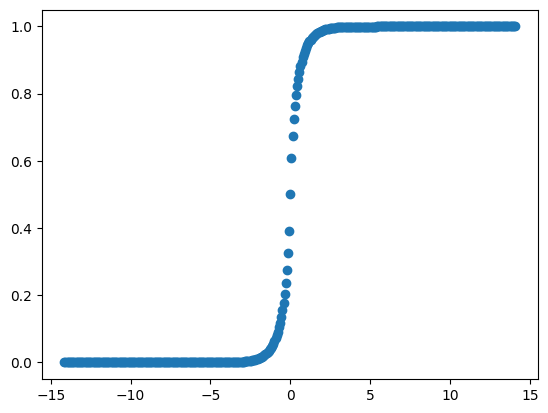

In [137]:
half_samples = num_samples // 2
mid = int(0.2*half_samples)
x = xs[half_samples - mid: half_samples + mid]
y = cdf(xs)[half_samples - mid: half_samples + mid]
plt.scatter(x, y)
plt.show()

linspline = interpolate.InterpolatedUnivariateSpline(x=x, y=y, k=3, ext='const')
invcdf = interpolate.InterpolatedUnivariateSpline(x=y, y=x, k=3, ext='const')

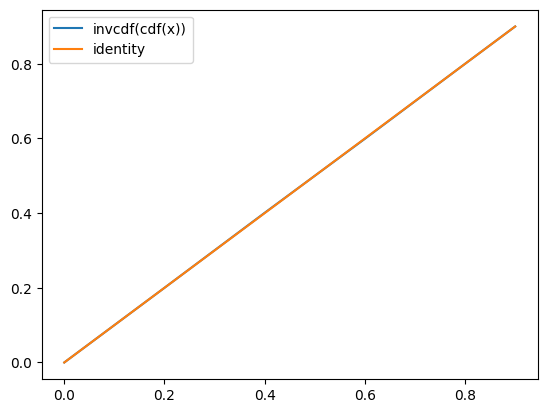

In [136]:
xx = np.arange(0, 1, 0.1)
yy = cdf(invcdf(xx))
plt.plot(xx, yy, label = "invcdf(cdf(x))")
plt.plot(xx, xx, label = 'identity')
plt.legend()

In [145]:
y = np.array([10, 13, 14, 18])
cutoffs = np.append(True, np.diff(y) > 2)
y[cutoffs]

# Strategy: Find all diffs, filter and form array where diffs are greater than threshold
# Create linear interplant in those regions

array([10, 13, 18])